In [1]:
import pandas as pd
import geopandas as gpd
import json
from pystac_client import Client
from copy import deepcopy
from shapely.geometry import shape

# convert a list of STAC Items into a GeoDataFrame
def items_to_geodataframe(items):
    _items = []
    for i in items:
        _i = deepcopy(i)
        _i['geometry'] = shape(_i['geometry'])
        _items.append(_i)
    gdf = gpd.GeoDataFrame(pd.json_normalize(_items))
    for field in ['properties.datetime', 'properties.created', 'properties.updated']:
        if field in gdf:
            gdf[field] = pd.to_datetime(gdf[field])
    gdf.set_index('properties.datetime', inplace=True)
    return gdf

### Create STAC client from USGS server, and inspect the collection types

In [2]:

URL = 'https://landsatlook.usgs.gov/stac-server'
cat = Client.open(URL)
print(cat)

collections = [(c.id, c.title) for c in cat.get_collections()]
pd.set_option("display.max_colwidth", 150)
df = pd.DataFrame(collections, columns=['id', 'title'])
df

<Client id=stac-server>


id  \
0   landsat-c1l2alb-st   
1      landsat-c2l2-sr   
2      landsat-c2l2-st   
3     landsat-c2ard-st   
4   landsat-c2l2alb-bt   
5     landsat-c2ard-bt   
6    landsat-c2l3-fsca   
7   landsat-c1l2alb-bt   
8         landsat-c2l1   
9      landsat-c2l3-ba   
10  landsat-c1l2alb-ta   
11  landsat-c2l2alb-st   
12    landsat-c2ard-sr   
13        landsat-c1l1   
14  landsat-c1l2alb-sr   
15  landsat-c2l2alb-ta   
16  landsat-c2l2alb-sr   
17    landsat-c2ard-ta   
18   landsat-c2l3-dswe   

                                                                                                               title  
0                                               Landsat Collection 1 Level-2 Albers Surface Temperature (ST) Product  
1                                                  Landsat Collection 2 Level-2 UTM Surface Reflectance (SR) Product  
2                                                  Landsat Collection 2 Level-2 UTM Surface Temperature (ST) Product  
3                        Landsat Collection 2 Analysis Ready Data (ARD) Level-2 UTM Surface Temperature (ST) Product  
4                          Landsat Collection 2 Level-2 Albers Top of Atmosphere Brightness Temperature (BT) Product  
5   Landsat Collection 2 Analysis Ready Data (ARD) Level-2 UTM Top of Atmosphere Brightness Temperature (BT) Product  
6                                           Landsat Collection 2 Level-3 Fractional Snow Covered Area (fSCA) Product  
7                          Landsat Collection 1 Level-2 Albers Top of Atmosphere Brightness Temperature (BT) Product  
8                                                                               Landsat Collection 2 Level-1 Product  
9                                                              Landsat Collection 2 Level-3 Burned Area (BA) Product  
10                                    Landsat Collection 1 Level-2 Albers Top of Atmosphere (TA) Reflectance Product  
11                                              Landsat Collection 2 Level-2 Albers Surface Temperature (ST) Product  
12                       Landsat Collection 2 Analysis Ready Data (ARD) Level-2 UTM Surface Reflectance (SR) Product  
13                                                                              Landsat Collection 1 Level-1 Product  
14                                              Landsat Collection 1 Level-2 Albers Surface Reflectance (SR) Product  
15                                    Landsat Collection 2 Level-2 Albers Top of Atmosphere (TA) Reflectance Product  
16                                              Landsat Collection 2 Level-2 Albers Surface Reflectance (SR) Product  
17             Landsat Collection 2 Analysis Ready Data (ARD) Level-2 UTM Top of Atmosphere (TA) Reflectance Product  
18                                          Landsat Collection 2 Level-3 Dynamic Surface Water Extent (DSWE) Product

### Lookup Collection 2, Level 2 surface temperatue and filter by aoi geometry
(This creates a STAC collection with all intersecting scenes through chosen datetime window)
### Overwrite asset hrefs with s3 link

In [3]:
collection_id = 'landsat-c2l2-st'
# aoi = gpd.read_file('../aois/bootleg-fire-wide.geojson') # Bootleg Fire - wide AOI for prelim analysis
aoi = gpd.read_file('../aois/bootleg-fire-cropped.geojson') # Bootleg Fire - zoomed in AOI with fewer unique path/ rows
# aoi = gpd.read_file('../aois/mcbride-fire.geojson') # McBride Fire

geom = json.loads(aoi['geometry'].to_json())['features'][0]['geometry']

# limit sets the # of items per page so we can see multiple pages getting fetched
search = cat.search(
    collections = [collection_id],
    intersects = aoi['geometry'][0],
    # datetime = "2022-04-01/2022-04-19",  # McBride Fire
    datetime = "2021-04-15/2021-09-30", # Bootleg Fire
    query = ["eo:cloud_cover<10"],
    limit = 100
)

# Get all items as a dictionary
items_dict = search.get_all_items_as_dict()['features']

# update URLs to use s3
for item in items_dict:
    for a in item['assets']:
        if 'alternate' in item['assets'][a] and 's3' in item['assets'][a]['alternate']:
            item['assets'][a]['href'] = item['assets'][a]['alternate']['s3']['href']
        item['assets'][a]['href'] = item['assets'][a]['href'].replace('usgs-landsat-ard', 'usgs-landsat')

# items_dict

In [4]:

# Create GeoDataFrame from Items
items_gdf = items_to_geodataframe(items_dict)

print(f"{len(items_dict)} items found")

pd.reset_option("display.max_colwidth")
items_gdf.head()

43 items found


type stac_version  \
properties.datetime                                      
2021-09-29 18:45:14.024014+00:00  Feature        1.0.0   
2021-09-29 18:44:50.132975+00:00  Feature        1.0.0   
2021-09-21 17:41:45.483485+00:00  Feature        1.0.0   
2021-09-21 17:41:21.600334+00:00  Feature        1.0.0   
2021-09-20 18:50:57.732659+00:00  Feature        1.0.0   

                                                                    stac_extensions  \
properties.datetime                                                                   
2021-09-29 18:45:14.024014+00:00  [https://landsat.usgs.gov/stac/landsat-extensi...   
2021-09-29 18:44:50.132975+00:00  [https://landsat.usgs.gov/stac/landsat-extensi...   
2021-09-21 17:41:45.483485+00:00  [https://landsat.usgs.gov/stac/landsat-extensi...   
2021-09-21 17:41:21.600334+00:00  [https://landsat.usgs.gov/stac/landsat-extensi...   
2021-09-20 18:50:57.732659+00:00  [https://landsat.usgs.gov/stac/landsat-extensi...   

                                                                           id  \
properties.datetime                                                             
2021-09-29 18:45:14.024014+00:00  LC08_L2SP_044031_20210929_20211013_02_T1_ST   
2021-09-29 18:44:50.132975+00:00  LC08_L2SP_044030_20210929_20211013_02_T1_ST   
2021-09-21 17:41:45.483485+00:00  LE07_L2SP_044031_20210921_20211017_02_T1_ST   
2021-09-21 17:41:21.600334+00:00  LE07_L2SP_044030_20210921_20211017_02_T1_ST   
2021-09-20 18:50:57.732659+00:00  LC08_L2SP_045030_20210920_20210925_02_T1_ST   

                                                                        description  \
properties.datetime                                                                   
2021-09-29 18:45:14.024014+00:00  Landsat Collection 2 Level-2 Surface Temperatu...   
2021-09-29 18:44:50.132975+00:00  Landsat Collection 2 Level-2 Surface Temperatu...   
2021-09-21 17:41:45.483485+00:00  Landsat Collection 2 Level-2 Surface Temperatu...   
2021-09-21 17:41:21.600334+00:00  Landsat Collection 2 Level-2 Surface Temperatu...   
2021-09-20 18:50:57.732659+00:00  Landsat Collection 2 Level-2 Surface Temperatu...   

                                                                               bbox  \
properties.datetime                                                                   
2021-09-29 18:45:14.024014+00:00  [-122.12520999759434, 40.69470995477723, -119....   
2021-09-29 18:44:50.132975+00:00  [-121.67894087723748, 42.11829828208518, -118....   
2021-09-21 17:41:45.483485+00:00  [-122.32260713567904, 40.8180269805176, -119.4...   
2021-09-21 17:41:21.600334+00:00  [-121.88263210486721, 42.247372843515656, -118...   
2021-09-20 18:50:57.732659+00:00  [-123.22141100407472, 42.11922552380305, -120....   

                                                                           geometry  \
properties.datetime                                                                   
2021-09-29 18:45:14.024014+00:00  POLYGON ((-121.58774 42.81047, -122.12521 41.0...   
2021-09-29 18:44:50.132975+00:00  POLYGON ((-121.12501 44.23762, -121.67894 42.5...   
2021-09-21 17:41:45.483485+00:00  POLYGON ((-121.83336 42.74434, -122.32261 41.1...   
2021-09-21 17:41:21.600334+00:00  POLYGON ((-121.37819 44.17046, -121.88263 42.5...   
2021-09-20 18:50:57.732659+00:00  POLYGON ((-122.66645 44.23875, -123.22141 42.5...   

                                                                              links  \
properties.datetime                                                                   
2021-09-29 18:45:14.024014+00:00  [{'rel': 'self', 'href': 'https://landsatlook....   
2021-09-29 18:44:50.132975+00:00  [{'rel': 'self', 'href': 'https://landsatlook....   
2021-09-21 17:41:45.483485+00:00  [{'rel': 'self', 'href': 'https://landsatlook....   
2021-09-21 17:41:21.600334+00:00  [{'rel': 'self', 'href': 'https://landsatlook....   
2021-09-20 18:50:57.732659+00:00  [{'rel': 'self', 'href': 'https://landsatlook....   

            

In [5]:
# items_gdf['assets.lwir11.alternate.s3.href'].values

In [6]:
import hvplot.pandas

def plot_polygons(data, *args, **kwargs):
    return data.hvplot.paths(*args, geo=True, tiles='OSM', xaxis=None, yaxis=None,
                             frame_width=600, frame_height=600,
                             line_width=3, **kwargs)

plot_polygons(aoi) * items_gdf.hvplot.paths(geo=True)

:Overlay
   .Tiles.I :Tiles   [x,y]
   .Path.I  :Path   [Longitude,Latitude]
   .Path.II :Path   [Longitude,Latitude]

In [7]:
import yaml

cfg = """---
landsat-c2l2-st:
  measurements:
    '*':
      dtype: uint16
      nodata: 0
      unit: 'm'
"""
cfg = yaml.load(cfg, Loader=yaml.CSafeLoader)

In [8]:
%%time
import stackstac
import pystac
from odc.stac import stac_load
from pyproj import CRS


# Create PySTAC ItemCollection
# item_collection = pystac.ItemCollection(items_dict[-2:])

item_collection = pystac.ItemCollection(items_dict)

# dir(item_collection[0])
epsg_code = item_collection[0].properties['proj:epsg']

%time stack = stackstac.stack(item_collection, epsg=CRS(('epsg', epsg_code)))

CPU times: user 2.5 s, sys: 171 ms, total: 2.67 s
Wall time: 6.32 s
CPU times: user 3.1 s, sys: 277 ms, total: 3.37 s
Wall time: 7.07 s


In [9]:
lst = stack.sel({'band':'lwir11'})*0.00341802 + 149.0

weekly = lst.resample(time="16D").median("time", keep_attrs=True)    # "~biweekly" Bootleg fire (Landsat-8 only)
# weekly = lst.resample(time="8D").median("time", keep_attrs=True)    # McBride fire (Landsat-8 & 9?)

### Generate UTM coords to filter dataset by AOI

In [10]:
import utm
import numpy as np

eastings = np.array([])
northings = np.array([])

# Had set up earlier to use midpoint + buffer, so need to init dataarray objects for coords
x_mid, y_mid = weekly.x.mean(), weekly.y.mean()

xmin = x_mid.copy()
xmax = x_mid.copy()
ymin = x_mid.copy()
ymax = x_mid.copy()

for point in aoi.geometry[0].exterior.coords:
    utm_coords = utm.from_latlon(point[1], point[0])

    eastings = np.append(eastings, utm_coords[0])
    northings = np.append(northings, utm_coords[1])

xmin.data = eastings.min()
xmax.data = eastings.max()
ymin.data = northings.min()
ymax.data = northings.max()

utm_aoi = weekly.loc[..., ymax:ymin, xmin:xmax]

### Collect *all* the images... note: this is ~2GB of data transfer from S3 for wide Bootleg Fire AOI

Make sure to have your `.env` set up for AWS access! See readme of this repo.

In [11]:
utm_aoi

<xarray.DataArray 'stackstac-77172c40a7df31da18a23fb1fbef614d' (time: 11,
                                                                y: 1105, x: 1358)>
dask.array<getitem, shape=(11, 1105, 1358), dtype=float64, chunksize=(1, 844, 763), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * time                         (time) datetime64[ns] 2021-04-21 ... 2021-09-28
    band                         <U9 'lwir11'
  * x                            (x) float64 6.239e+05 6.24e+05 ... 6.646e+05
  * y                            (y) float64 4.742e+06 4.742e+06 ... 4.709e+06
    landsat:wrs_type             <U1 '2'
    landsat:collection_category  <U2 'T1'
    ...                           ...
    description                  object 'Landsat Collection 2 Level-2 Surface...
    title                        <U46 'Surface Temperature Band (B10)'
    common_name                  object 'lwir11'
    center_wavelength            object 10.9
    full_width_half_max          object None
    epsg                         object epsg:32610

In [12]:
from rasterio.session import AWSSession

import dask.diagnostics
with dask.diagnostics.ProgressBar():
    data = utm_aoi.compute()

[#####                                   ] | 14% Completed |  5.0s

/Users/kevinlalli/miniconda3/envs/odc-stac/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


[########################################] | 100% Completed | 53.6s


### Plot all the images (or make very big GIF)

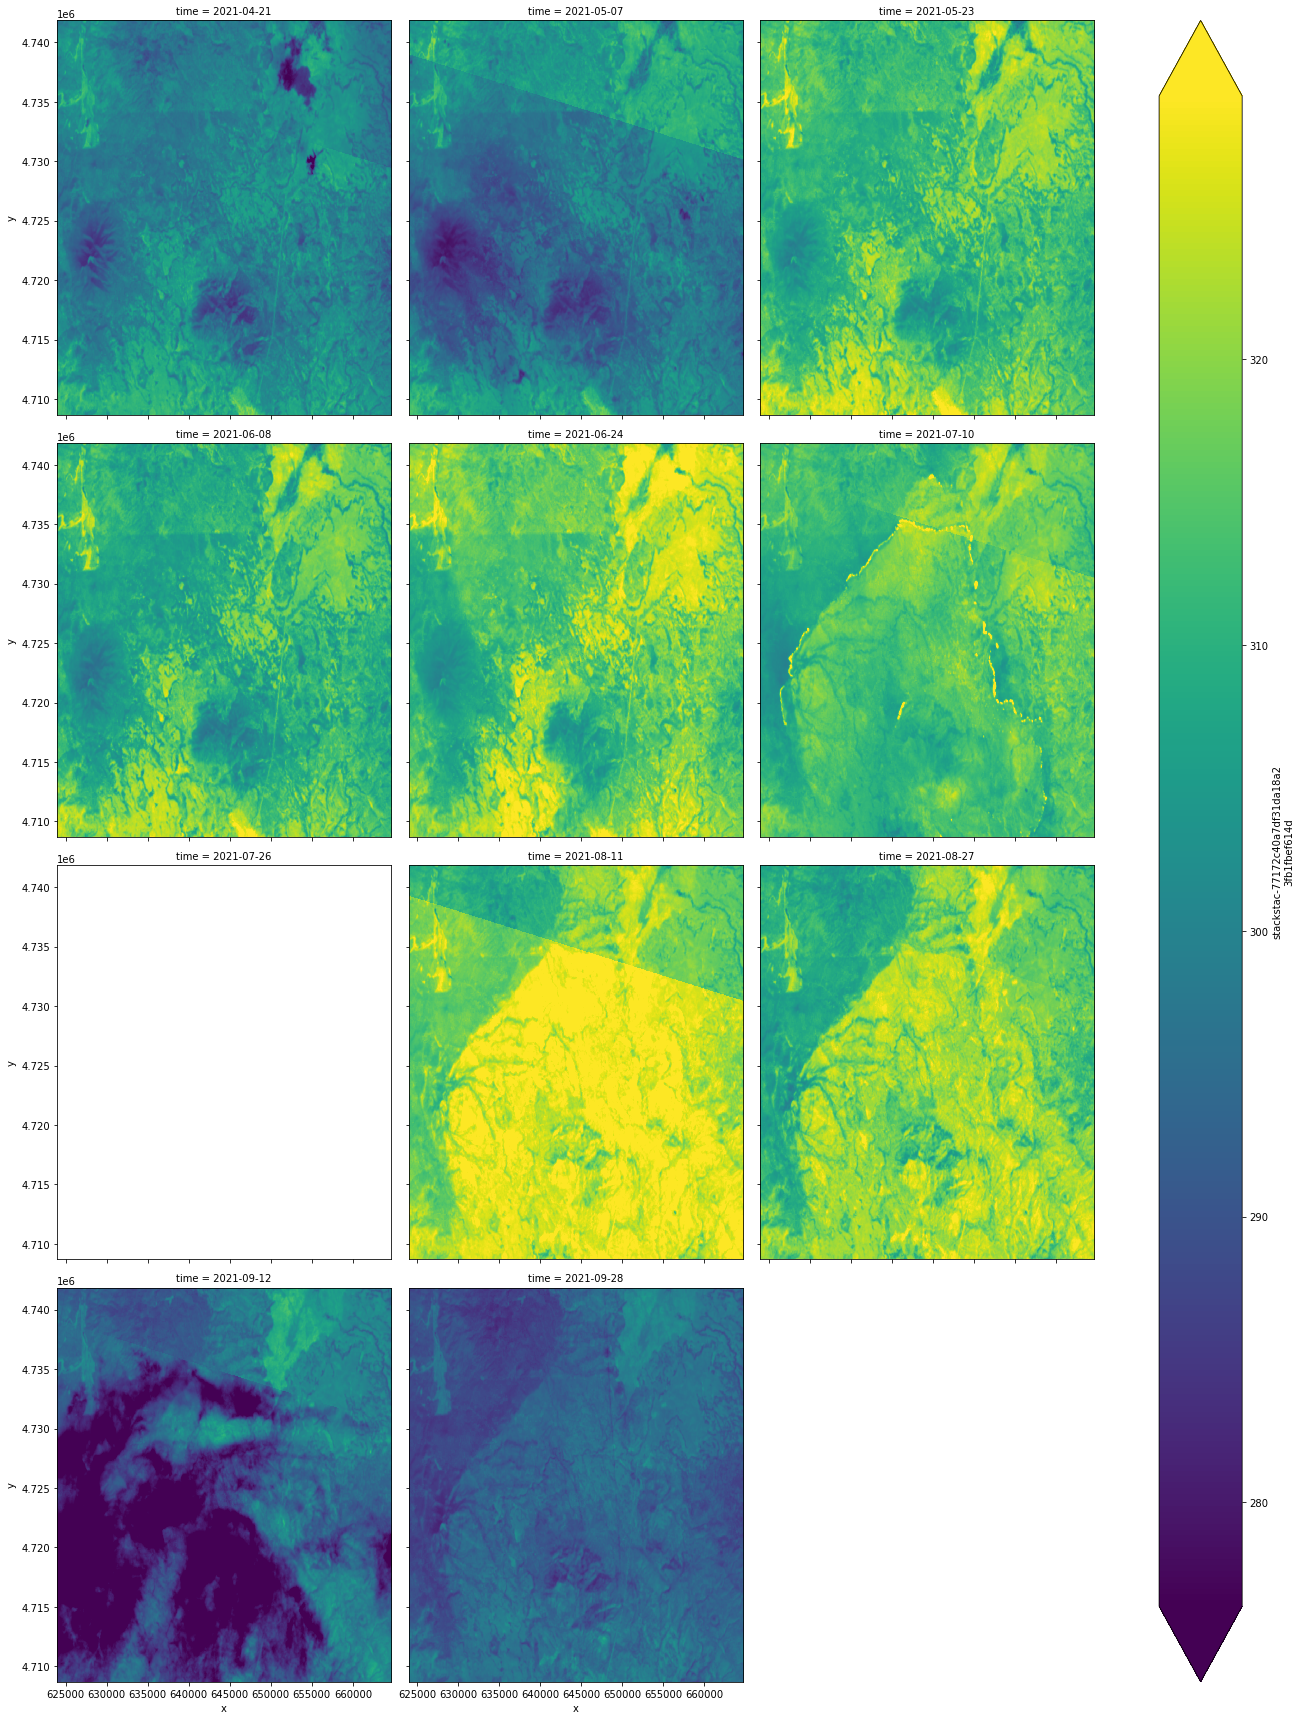

In [13]:
data.plot.imshow(col="time", col_wrap=3, robust=True, size=6);
# gif(data, fps=1, cmap='plasma', vmin=240, vmax=360)

### Tighten crop on data, downsample, and make a more reasonable GIF

If e.g. using `bootleg-fire-wide.geojson` to start with a w

In [14]:
aoi = gpd.read_file('../aois/bootleg-fire-cropped.geojson')

for point in aoi.geometry[0].exterior.coords:
    # print(point[0], point[1])
    # print(utm.from_latlon(point[1], point[0]))

    utm_coords = utm.from_latlon(point[1], point[0])

    eastings = np.append(eastings, utm_coords[0])
    northings = np.append(northings, utm_coords[1])


# eastings

xmin.data = eastings.min()
xmax.data = eastings.max()
ymin.data = northings.min()
ymax.data = northings.max()

utm_aoi = data.loc[..., ymax:ymin, xmin:xmax]

In [15]:
from geogif import gif

# Downsample for GIF
reduced = utm_aoi.coarsen(x=4, y=4, boundary="trim").mean()

gif(reduced, to='./output/test_gif_v0.gif', fps=1, cmap='plasma', vmin=280, vmax=380)